In [12]:
ee.Initialize(project='ee-farming28')

In [9]:
import ee
import geemap
ee.Authenticate()  # Do this once to set up authentication
#ee.Initialize()

True

In [14]:
Map=geemap.Map()
Map.add_basemap('SATELLITE')  # Adds satellite imagery as base layer

# Center the map on a location (use your coordinates)
Map.setCenter(78.9629, 20.5937, zoom=12)  # longitude, latitude, zoom level

# Display the map
display(Map)

Map(center=[20.5937, 78.9629], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [15]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.9 MB/s eta 0:00:00



Field Analysis Recommendations:
--------------------------------

Region 0:
- Current Measurements:
  Water Status (NDWI): -0.384
  Vegetation Health (NDVI): 0.424
  Soil Moisture (NDMI): 0.153
- URGENT: Critical water shortage detected. Immediate irrigation needed. Current water level is significantly below optimal range.
- Moderate vegetation health. Monitor for changes and consider preventive nutrient application.

Region 1:
- Current Measurements:
  Water Status (NDWI): -0.198
  Vegetation Health (NDVI): 0.196
  Soil Moisture (NDMI): 0.058
- URGENT: Critical water shortage detected. Immediate irrigation needed. Current water level is significantly below optimal range.
- ALERT: Poor crop health detected. Consider fertilizer application and check for pest infestation or disease. Vegetation index indicates suboptimal growth.

Region 2:
- Current Measurements:
  Water Status (NDWI): -0.482
  Vegetation Health (NDVI): 0.544
  Soil Moisture (NDMI): 0.240
- URGENT: Critical water shortag

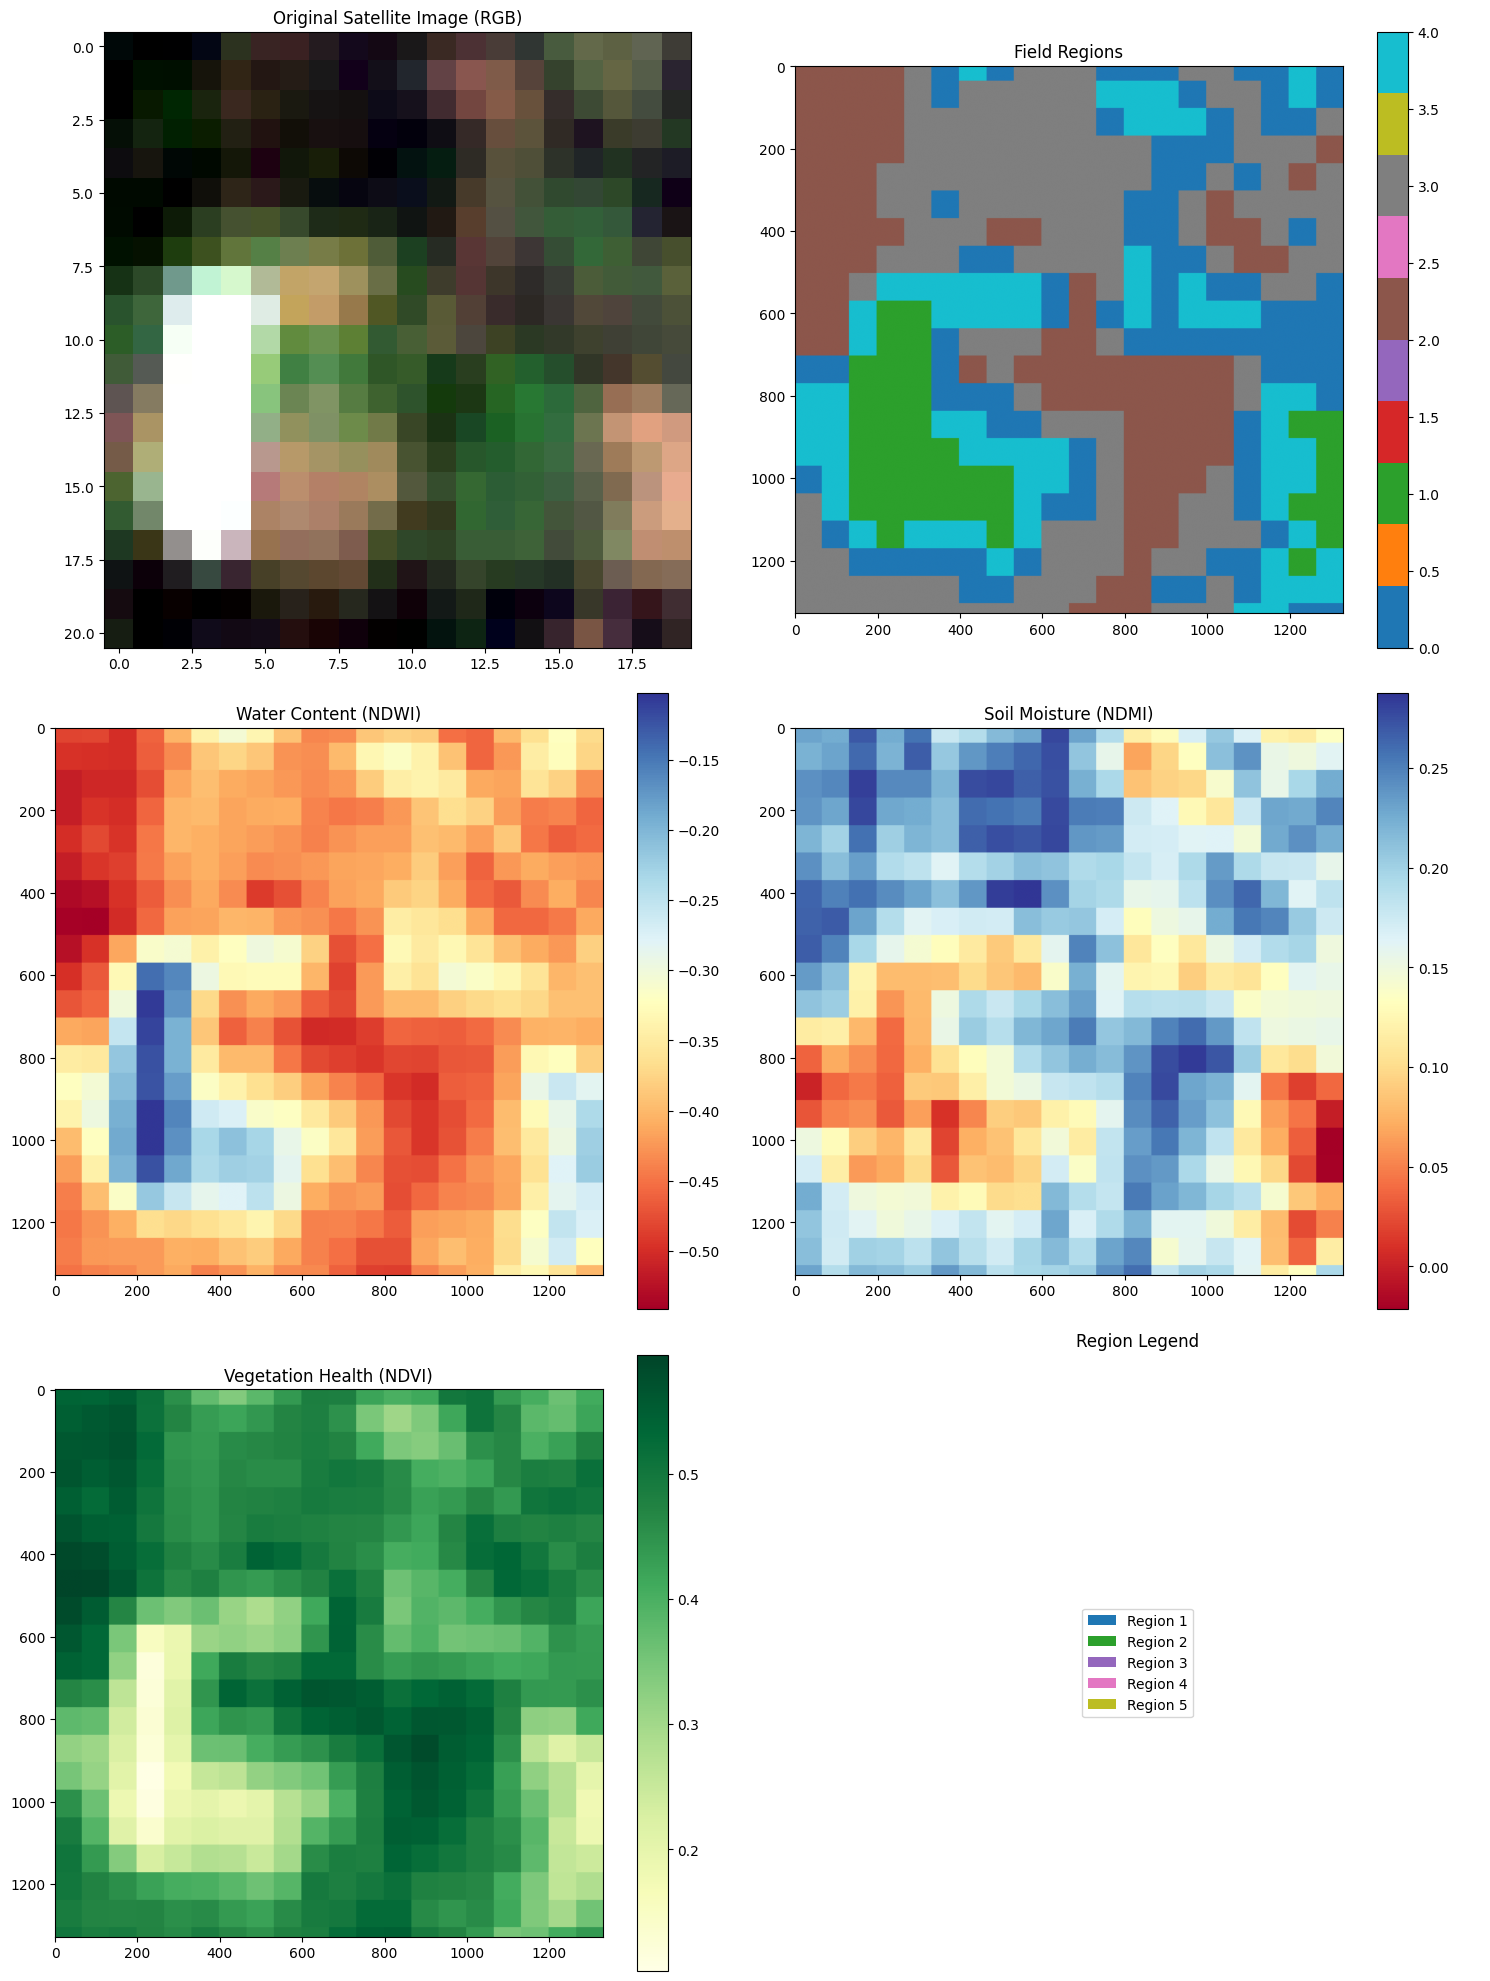

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

class PaddyFieldAnalyzer:
    def _init_(self):
        """Initialize the analyzer with Earth Engine"""
        ee.Initialize()

    def get_field_boundary(self, latitude, longitude, radius=100):
        """Create a boundary around the field center point"""
        point = ee.Geometry.Point([longitude, latitude])
        return point.buffer(radius)

    def get_satellite_data(self, boundary, start_date, end_date):
        """Fetch and prepare satellite imagery"""
        s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(boundary) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
            .first()

        # Select bands for analysis
        bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
        return s2.select(bands)




    def get_satellite_rgb(self, image, region):
      """Extract RGB bands and convert to numpy array for visualization"""
      # Select RGB bands (B4=Red, B3=Green, B2=Blue)
      rgb_image = image.select(['B4', 'B3', 'B2'])

      # Get the data as numpy arrays
      rgb_array = geemap.ee_to_numpy(rgb_image, region=region, scale=10)

      # Enhanced normalization for natural color appearance
      rgb_normalized = np.zeros_like(rgb_array, dtype=np.float32)

      for i in range(3):
          band = rgb_array[:,:,i]
          valid_mask = ~np.isnan(band)
          if np.any(valid_mask):
              # Adjust percentiles for better contrast
              min_val = np.percentile(band[valid_mask], 5)
              max_val = np.percentile(band[valid_mask], 95)

              if max_val > min_val:
                  # Apply gamma correction for better visualization
                  normalized = np.clip((band - min_val) / (max_val - min_val), 0, 1)
                  rgb_normalized[:,:,i] = np.power(normalized, 0.8)  # Gamma correction

      # Color enhancement for vegetation
      # Slightly boost green channel for better vegetation visibility
      rgb_normalized[:,:,1] = np.clip(rgb_normalized[:,:,1] * 1.1, 0, 1)

      # Ensure no NaN values
      rgb_normalized = np.nan_to_num(rgb_normalized, nan=0.0)

      return rgb_normalized

    def calculate_indices(self, image, region):
        """Calculate indices and convert to numpy arrays"""
        # Calculate indices as Earth Engine images
        ndvi = image.normalizedDifference(['B8', 'B4'])
        ndwi = image.normalizedDifference(['B3', 'B8'])
        ndmi = image.normalizedDifference(['B8', 'B11'])

        # Define parameters for downloading
        scale = 0.15  # 10m resolution for Sentinel-2

        # Get the data as numpy arrays
        ndvi_array = geemap.ee_to_numpy(ndvi, region=region, scale=scale)
        ndwi_array = geemap.ee_to_numpy(ndwi, region=region, scale=scale)
        ndmi_array = geemap.ee_to_numpy(ndmi, region=region, scale=scale)

        return {
            'ndvi': ndvi_array,
            'ndwi': ndwi_array,
            'ndmi': ndmi_array
        }

    def segment_field(self, indices, num_regions=5):
        """Segment field into regions based on health indicators"""
        # Stack the arrays
        combined_data = np.stack([
            indices['ndvi'],
            indices['ndwi'],
            indices['ndmi']
        ], axis=-1)

        # Reshape for clustering
        valid_shape = combined_data.shape[:2]
        flat_data = combined_data.reshape(-1, 3)

        # Remove NaN values
        valid_pixels = ~np.isnan(flat_data).any(axis=1)
        flat_data_clean = flat_data[valid_pixels]

        # Perform clustering
        kmeans = KMeans(n_clusters=num_regions, random_state=42)
        clusters = kmeans.fit_predict(flat_data_clean)

        # Reconstruct the segmentation map
        full_clusters = np.full(flat_data.shape[0], -1)
        full_clusters[valid_pixels] = clusters

        return full_clusters.reshape(valid_shape)

    def analyze_regions(self, segments, indices):
        """Analyze each region's health status"""
        region_analysis = {}

        for region_id in np.unique(segments[segments != -1]):
            mask = segments == region_id

            region_analysis[region_id] = {
                'water_status': np.nanmean(indices['ndwi'][mask]),
                'soil_moisture': np.nanmean(indices['ndmi'][mask]),
                'vegetation_health': np.nanmean(indices['ndvi'][mask])
            }

        return region_analysis



    def generate_recommendations(self, region_analysis):
      """Generate detailed region-specific recommendations"""
      recommendations = {}

      for region_id, metrics in region_analysis.items():
          recommendations[region_id] = []

          # Add current metrics
          recommendations[region_id].append(
              f"Current Measurements:\n"
              f"  Water Status (NDWI): {metrics['water_status']:.3f}\n"
              f"  Vegetation Health (NDVI): {metrics['vegetation_health']:.3f}\n"
              f"  Soil Moisture (NDMI): {metrics['soil_moisture']:.3f}"
          )

          # Water recommendations with context
          if metrics['water_status'] < 0.1:
              recommendations[region_id].append(
                  "URGENT: Critical water shortage detected. Immediate irrigation needed. "
                  "Current water level is significantly below optimal range."
              )
          elif metrics['water_status'] < 0.3:
              recommendations[region_id].append(
                  "WARNING: Moderate water stress detected. Consider irrigation within next few days. "
                  "Water levels are below optimal range."
              )
          else:
              recommendations[region_id].append(
                  "Water levels are within acceptable range."
              )

          # Vegetation health recommendations with context
          if metrics['vegetation_health'] < 0.3:
              recommendations[region_id].append(
                  "ALERT: Poor crop health detected. Consider fertilizer application and "
                  "check for pest infestation or disease. Vegetation index indicates "
                  "suboptimal growth."
              )
          elif metrics['vegetation_health'] < 0.5:
              recommendations[region_id].append(
                  "Moderate vegetation health. Monitor for changes and consider "
                  "preventive nutrient application."
              )
          else:
              recommendations[region_id].append(
                  "Vegetation health is good."
              )

          # Soil moisture interpretation
          if metrics['soil_moisture'] < 0:
              recommendations[region_id].append(
                  "Soil moisture is below average. Consider soil amendments to "
                  "improve water retention."
              )

      return recommendations


    def visualize_all(self, rgb_image, segments, indices):
        """Create visualizations including original satellite image"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 20))

        # Plot original satellite image
        axes[0, 0].imshow(rgb_image)
        axes[0, 0].set_title('Original Satellite Image (RGB)')

        # Plot segmented regions
        seg_plot = axes[0, 1].imshow(segments, cmap='tab10')
        axes[0, 1].set_title('Field Regions')
        plt.colorbar(seg_plot, ax=axes[0, 1])

        # Plot water content
        water_plot = axes[1, 0].imshow(indices['ndwi'], cmap='RdYlBu')
        axes[1, 0].set_title('Water Content (NDWI)')
        plt.colorbar(water_plot, ax=axes[1, 0])

        # Plot soil moisture
        moisture_plot = axes[1, 1].imshow(indices['ndmi'], cmap='RdYlBu')
        axes[1, 1].set_title('Soil Moisture (NDMI)')
        plt.colorbar(moisture_plot, ax=axes[1, 1])

        # Plot vegetation health
        health_plot = axes[2, 0].imshow(indices['ndvi'], cmap='YlGn')
        axes[2, 0].set_title('Vegetation Health (NDVI)')
        plt.colorbar(health_plot, ax=axes[2, 0])

        # Add legend for regions
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=plt.cm.tab10(i/5))
                         for i in range(5)]
        axes[2, 1].legend(legend_elements, [f'Region {i+1}' for i in range(5)],
                         loc='center')
        axes[2, 1].axis('off')
        axes[2, 1].set_title('Region Legend')

        plt.tight_layout()
        return fig

def main():
    # Initialize analyzer
    analyzer = PaddyFieldAnalyzer()

    # Example coordinates (replace with actual field coordinates)
    latitude = -6.6837  # Latitude for 6°41'10'' S
    longitude = 107.5503

    # Get field boundary
    boundary = analyzer.get_field_boundary(latitude, longitude)

    try:
        # Get satellite data
        image = analyzer.get_satellite_data(
            boundary,
            start_date='2023-12-01',
            end_date='2023-12-31'
        )

        # Get RGB visualization
        rgb_image = analyzer.get_satellite_rgb(image, boundary)

        # Calculate indices
        indices = analyzer.calculate_indices(image, boundary)

        # Segment field
        segments = analyzer.segment_field(indices)

        # Analyze regions
        region_analysis = analyzer.analyze_regions(segments, indices)

        # Generate recommendations
        recommendations = analyzer.generate_recommendations(region_analysis)

        # Visualize results
        fig = analyzer.visualize_all(rgb_image, segments, indices)

        return recommendations, fig, rgb_image

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None, None

    if visualization is not None:
        plt.show()



if __name__ == "__main__":
    recommendations, visualization, rgb_image = main()

# Print recommendations (fixed format)
print("\nField Analysis Recommendations:")
print("--------------------------------")
for region_id, recs in recommendations.items():
    print(f"\nRegion {region_id}:")
    if recs:  # Check if there are any recommendations
        for rec in recs:
            print(f"- {rec}")
    else:
        print("- No specific recommendations for this region.")


In [67]:
import geemap
import ee

# Initialize Earth Engine
ee.Initialize()

# Create a Map object
Map = geemap.Map()

# Add satellite imagery as a base layer
Map.add_basemap('SATELLITE')

# Define the coordinates for the location (latitude, longitude)
latitude = -6.6837  # Latitude for 6°41'10'' S
longitude = 107.5503  # Longitude for 107°33'10'' E

# Set the center of the map to the coordinates with a zoom level of 12
Map.setCenter(longitude, latitude, zoom=18)

# Create a point geometry for the specified latitude and longitude
point = ee.Geometry.Point([longitude, latitude])

# Create a 100m buffer around the point (100 meters radius)
buffer = point.buffer(100)  # 100 meters

# Add the buffer to the map for visualization
Map.addLayer(buffer, {'color': 'red'}, '100m Buffer')

# Display the map
display(Map)


Map(center=[-6.6837, 107.5503], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…